# Number of participants (sample size)

One of the first things we started annotating is the number of participants for each study.
More annotations are needed, and we need to harmonize the way this is done across projects (in particular the label names), but these annotations can already give an approximation of the number of participants in typical MRI studies, and be used to validate systems that aim to extract that information automatically.

## Loading the data

In [1]:
import pandas as pd

from labelrepo import database

connection = database.get_database_connection()

annotations = pd.read_sql(
    """
    SELECT selected_text, extra_data, publication_year, pmcid
    FROM  detailed_annotation
    WHERE label_name IN
      ("N included", "n_participants", "n_participants_total", "N_Total")
    """,
    connection,
)

annotations.head()

,selected_text,extra_data,publication_year,pmcid
0,Eighty‐three,None,2021,8785614
1,eleven,None,2014,4019522
2,11,None,2014,4019522
3,14,None,2013,3855767
4,Twenty one,None,2011,3106359


## Converting the annotated text to integers

In some cases, the text providing the number of participants has been highlighted but still needs to be converted to an actual number, as "Twenty-four" above.
In some other cases, the annotator indicated the numerical value in the `extra_data` column:

In [2]:
annotations[annotations["extra_data"].notnull()].head()

,selected_text,extra_data,publication_year,pmcid
196,wo adolescent participants were excluded,104,2019,6664004
198,Two male participants did not complete MR scan...,54,2021,7779563
199,"The data for these three subjects were, theref...",22,2012,3483694
201,"Finally, 58 patients with EOD, 62 patients wit...",232,2017,5598991
204,sixteen,16,2017,5537800


The following is just defining a function, `text_to_number`, for converting text to numbers, for example "Twenty-four" → 24. 
You can skip over it as it is not very relevant to the rest of this notebook.

In [3]:
import re

import lark

numbers_grammar = r"""
number: NUMBER | text_number

?text_number.1: hundred_text_number | dozen_text_number | TEEN_NAME | UNIT_NAME


hundred_text_number.1: (dozen_text_number | UNIT_NAME) "hundred" [ "and" ] [ dozen_text_number | UNIT_NAME ]

dozen_text_number.1: DOZEN_NAME [ UNIT_NAME ] | TEEN_NAME

UNIT_NAME.1: "one"|"two"|"three"|"four"|"five"|"six"|"seven"|"eight"|"nine"

TEEN_NAME.1: "ten"|"eleven"|"twelve"|"thirteen"|"fourteen"|"fifteen"
    |"sixteen"|"seventeen"|"eighteen"|"nineteen"

DOZEN_NAME.1: "twenty"|"thirty"|/fou?rty/|"fifty"|"sixty"|"seventy"|"eighty"
    |"ninety"


WS: /\s+/
PUNCT: /[^a-zA-Z0-9().]/

%import common (NUMBER)
%ignore WS
%ignore PUNCT
"""


class NumberTransformer(lark.Transformer):
    def number(self, tree) -> int:
        return tree[0]

    def hundred_text_number(self, tree) -> int:
        hundred_part, rest = tree
        if rest is None:
            return 100 * hundred_part
        return 100 * hundred_part + rest

    def dozen_text_number(self, tree) -> int:
        if len(tree) == 1:
            teen = tree[0]
            return teen
        dozen, unit = tree
        if unit is None:
            return dozen
        return dozen + unit

    def UNIT_NAME(self, tree) -> int:
        return (
            "zero one two three four five six seven eight nine".split().index(
                tree.value.lower()
            )
        )

    def TEEN_NAME(self, tree) -> int:
        return (
            "ten eleven twelve thirteen fourteen fifteen sixteen "
            "seventeen eighteen nineteen".split().index(tree.value.lower())
            + 10
        )

    def DOZEN_NAME(self, tree) -> int:
        return (
            "zero ten twenty thirty forty fifty sixty "
            "seventy eighty ninety".split().index(
                tree.value.lower().replace("fourty", "forty")
            )
        ) * 10

    def NUMBER(self, tree) -> int:
        return int(tree.value)


class TextToNumber:
    def __init__(self):
        self.parser = lark.Lark(
            numbers_grammar,
            ambiguity="resolve",
            start="number",
            g_regex_flags=re.I,
        )
        self.transformer = NumberTransformer()

    def __call__(self, text):
        try:
            parse_tree = self.parser.parse(text.replace(",", ""))
            return self.transformer.transform(parse_tree)
        except Exception:
            return None


text_to_number = TextToNumber()

Now that we have the `text_to_number` function we use it to get the value for the number of participants wherever possible:

In [4]:
def get_n_participants(row):
    try:
        return int(row["extra_data"])
    except (TypeError, ValueError):
        return text_to_number(row["selected_text"])

annotations["n_participants"] = annotations.apply(get_n_participants, axis=1)
annotations.dropna(subset=["n_participants"], inplace=True)
annotations["n_participants"] = annotations["n_participants"].astype(int)

annotations.head()

,selected_text,extra_data,publication_year,pmcid,n_participants
0,Eighty‐three,None,2021,8785614,83
1,eleven,None,2014,4019522,11
2,11,None,2014,4019522,11
3,14,None,2013,3855767,14
4,Twenty one,None,2011,3106359,21


## Distribution of sample sizes

In case there are several annotations for the number of participants in the same article, we keep the largest one.

In [5]:
annotations = annotations.sort_values(
    by="n_participants", ascending=False
).drop_duplicates(subset="pmcid")

Now we plot in a histogram the distribution of sample sizes:

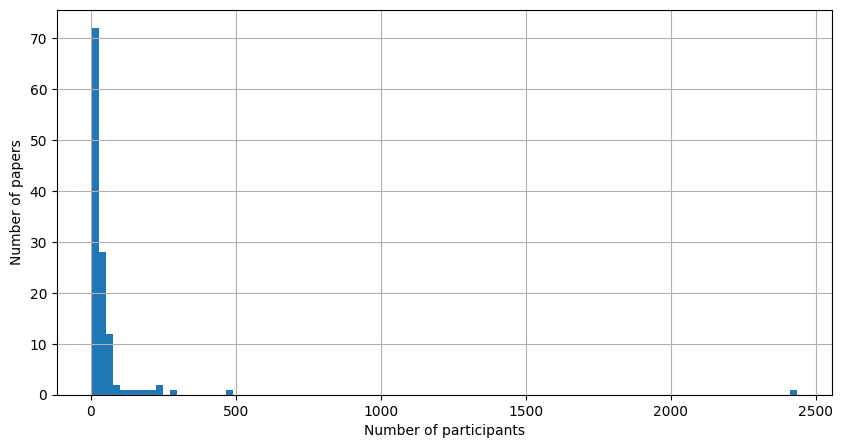

In [6]:
from matplotlib import pyplot as plt

fig, ax = plt.subplots(figsize=(10, 5))
annotations["n_participants"].hist(bins=100, ax=ax)
_ = ax.set_ylabel("Number of papers")
_ = ax.set_xlabel("Number of participants")

One of the papers seems to have a very large sample size; but if we display the annotations we realize it's actually aggregating data from multiple studies:

In [7]:
from labelrepo import displays

first_paper_anno = connection.execute(
    """
    select *
    from detailed_annotation
    where label_name = 'n_participants' and pmcid = ?
    """,
    [int(annotations["pmcid"].iat[0])],
).fetchall()
displays.AnnotationsDisplay(first_paper_anno)

## Sample sizes over time

We now display individual article's sample size and publication year:

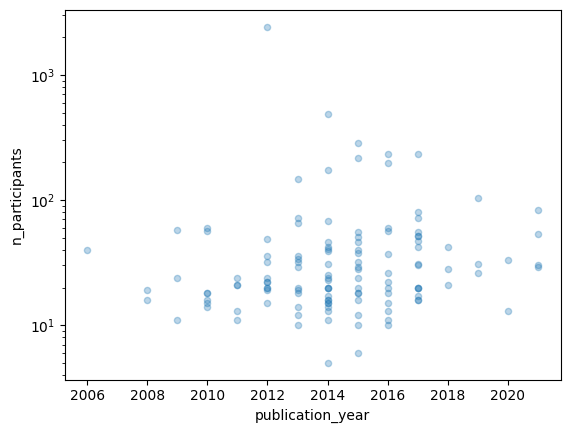

In [8]:
fig, ax = plt.subplots()
annotations.plot.scatter(x="publication_year", y="n_participants", ax=ax, alpha=0.3)
ax.set_yscale("log")